In [11]:
!nvidia-smi

import torch, torchvision, timm
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("timm:", timm.__version__)
print("CUDA available:", torch.cuda.is_available())


Mon Aug 11 09:07:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             31W /   70W |    3393MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
from pathlib import Path

DATASET_DIR = Path("/kaggle/input/skin-cancer-mnist-ham10000")  

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42
MODEL_NAME = "efficientnet_b0"

# Create output dir
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(exist_ok=True)


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Expect dataset in subfolders: class_name/image.jpg
files, labels = [], []
for p in DATASET_DIR.rglob("*.jpg"):
    files.append(str(p))
    labels.append(p.parent.name)

df = pd.DataFrame({"filepath": files, "label": labels})

# Encode labels
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])
CLASSES = list(le.classes_)
NUM_CLASSES = len(CLASSES)

# Train/val split
train_df, val_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df["y"])

print("Classes:", CLASSES)
print(len(train_df), "train /", len(val_df), "val")


Classes: ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'ham10000_images_part_2']
17025 train / 3005 val


In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as T

train_tfms = T.Compose([
    T.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])


val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

class ImageDS(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.filepath).convert("RGB")
        img = self.tfms(img)
        y = torch.tensor(row.y).long()
        return img, y

train_ds = ImageDS(train_df, train_tfms)
val_ds   = ImageDS(val_df,   val_tfms)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)


In [20]:
!pip install -q tqdm


In [21]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

# Make sure dataloaders use multiple workers for speed
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

from collections import Counter
import torch.nn as nn


class_counts = Counter(train_df["y"])
weights = torch.tensor([1.0 / class_counts[i] for i in range(NUM_CLASSES)], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss, train_correct = 0, 0
    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_correct += (preds.argmax(1) == yb).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    for xb, yb in tqdm(val_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
        xb, yb = xb.to(device), yb.to(device)
        with torch.no_grad():
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (preds.argmax(1) == yb).sum().item()

    train_acc = train_correct / len(train_ds)
    val_acc   = val_correct / len(val_ds)
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Acc: {train_acc:.3f} "
          f"| Val Acc: {val_acc:.3f}")


Epoch 1/20 [Val]: 100%|██████████| 94/94 [00:18<00:00,  5.12it/s]


Epoch 1/20 | Train Acc: 0.272 | Val Acc: 0.289


Epoch 2/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Epoch 2/20 | Train Acc: 0.295 | Val Acc: 0.280


Epoch 3/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.71it/s]


Epoch 3/20 | Train Acc: 0.309 | Val Acc: 0.291


Epoch 4/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.57it/s]


Epoch 4/20 | Train Acc: 0.316 | Val Acc: 0.308


Epoch 5/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.67it/s]


Epoch 5/20 | Train Acc: 0.320 | Val Acc: 0.315


Epoch 6/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.56it/s]


Epoch 6/20 | Train Acc: 0.326 | Val Acc: 0.306


Epoch 7/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.80it/s]


Epoch 7/20 | Train Acc: 0.326 | Val Acc: 0.313


Epoch 8/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.70it/s]


Epoch 8/20 | Train Acc: 0.336 | Val Acc: 0.307


Epoch 9/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.76it/s]


Epoch 9/20 | Train Acc: 0.340 | Val Acc: 0.288


Epoch 10/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.71it/s]


Epoch 10/20 | Train Acc: 0.342 | Val Acc: 0.307


Epoch 11/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.68it/s]


Epoch 11/20 | Train Acc: 0.351 | Val Acc: 0.293


Epoch 12/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.76it/s]


Epoch 12/20 | Train Acc: 0.361 | Val Acc: 0.296


Epoch 13/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.62it/s]


Epoch 13/20 | Train Acc: 0.358 | Val Acc: 0.302


Epoch 14/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.74it/s]


Epoch 14/20 | Train Acc: 0.378 | Val Acc: 0.293


Epoch 15/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s]


Epoch 15/20 | Train Acc: 0.388 | Val Acc: 0.293


Epoch 16/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.77it/s]


Epoch 16/20 | Train Acc: 0.400 | Val Acc: 0.288


Epoch 17/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.65it/s]


Epoch 17/20 | Train Acc: 0.413 | Val Acc: 0.311


Epoch 18/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.74it/s]


Epoch 18/20 | Train Acc: 0.420 | Val Acc: 0.301


Epoch 19/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.69it/s]


Epoch 19/20 | Train Acc: 0.433 | Val Acc: 0.288


Epoch 20/20 [Val]: 100%|██████████| 94/94 [00:16<00:00,  5.81it/s]

Epoch 20/20 | Train Acc: 0.438 | Val Acc: 0.293


In [22]:
torch.save({
    "model": model.state_dict(),
    "classes": CLASSES
}, OUTPUT_DIR / "efficientnet_b0_skin_cancer.pth")

print("Model saved to:", OUTPUT_DIR / "efficientnet_b0_skin_cancer.pth")


Model saved to: /kaggle/working/efficientnet_b0_skin_cancer.pth


In [23]:
import os, torch

ckpt_path = OUTPUT_DIR / "best_model.pth"  # change if you used a different name
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model"])
    CLASSES = ckpt.get("classes", CLASSES)
    print("Loaded best checkpoint:", ckpt_path)
else:
    print("No best checkpoint found. Using the current model in memory.")
    
model.to(device).eval()
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES)


No best checkpoint found. Using the current model in memory.
Classes: ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'ham10000_images_part_2']


In [24]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

all_preds, all_gts = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_gts.extend(yb.numpy())

val_acc = accuracy_score(all_gts, all_preds)
print(f"Validation Accuracy: {val_acc:.4f}\n")
print(classification_report(all_gts, all_preds, target_names=CLASSES, digits=4))


Validation Accuracy: 0.2928

                        precision    recall  f1-score   support

HAM10000_images_part_1     0.2474    0.1880    0.2136       750
HAM10000_images_part_2     0.3476    0.5199    0.4166       752
ham10000_images_part_1     0.2948    0.4013    0.3399       750
ham10000_images_part_2     0.1626    0.0624    0.0902       753

              accuracy                         0.2928      3005
             macro avg     0.2631    0.2929    0.2651      3005
          weighted avg     0.2630    0.2928    0.2650      3005



<Figure size 600x600 with 0 Axes>

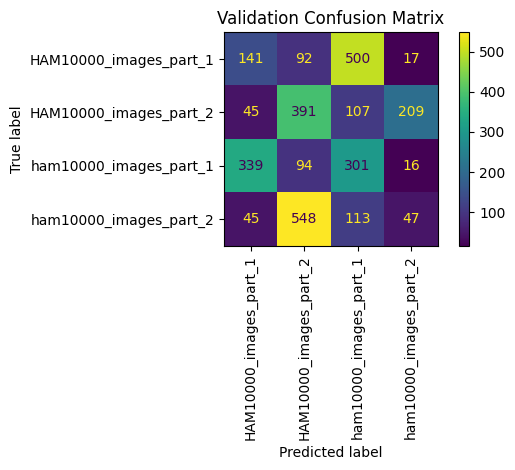

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_gts, all_preds, labels=list(range(NUM_CLASSES)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(6,6))
disp.plot(xticks_rotation=90, values_format='d')
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()


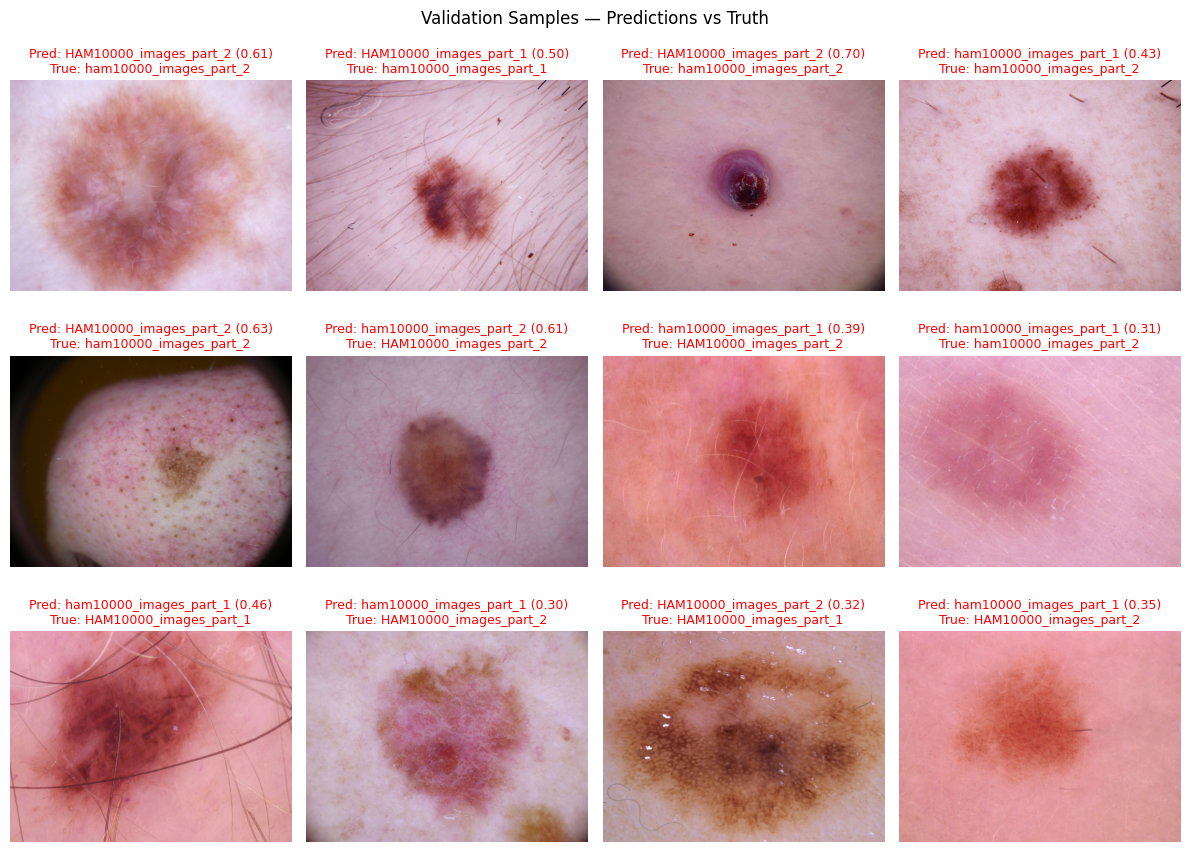

In [26]:
import random
from PIL import Image
import torchvision.transforms as T

to_img = T.ToPILImage()

# pick some random validation rows
sample_rows = val_df.sample(n=min(12, len(val_df)), random_state=0).reset_index(drop=True)

plt.figure(figsize=(12,9))
for i in range(len(sample_rows)):
    row = sample_rows.iloc[i]
    img = Image.open(row.filepath).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = probs.argmax()
        pred, conf = CLASSES[pred_idx], probs[pred_idx]

    true_label = CLASSES[row.y]
    correct = (pred == true_label)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    title = f"Pred: {pred} ({conf:.2f})\nTrue: {true_label}"
    plt.title(title, color=("green" if correct else "red"), fontsize=9)
    plt.axis("off")

plt.suptitle("Validation Samples — Predictions vs Truth", fontsize=12)
plt.tight_layout()
plt.show()


In [27]:
save_path = OUTPUT_DIR / "efficientnet_b0_skin_cancer.pth"
torch.save({"model": model.state_dict(), "classes": CLASSES}, save_path)
print("Saved:", save_path)

# also save a small README so Kaggle “Create Dataset” has context
with open(OUTPUT_DIR / "README.txt", "w") as f:
    f.write(
        "EfficientNet-B0 fine-tuned on skin-lesion images.\n"
        f"Classes: {', '.join(CLASSES)}\n"
        "Load with:\n"
        "  ckpt = torch.load('efficientnet_b0_skin_cancer.pth', map_location='cpu')\n"
        "  model.load_state_dict(ckpt['model'])\n"
        "  classes = ckpt['classes']\n"
    )
print("Saved:", OUTPUT_DIR / "README.txt")


Saved: /kaggle/working/efficientnet_b0_skin_cancer.pth
Saved: /kaggle/working/README.txt
